In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

     sociality  sociality75pc  shifted_sociality75pc
0         1.00           1.00               1.000000
1         1.00           1.00               1.000000
2         1.00           1.00               1.000000
3         1.00           1.00               1.000000
4         1.00           1.00               1.000000
..         ...            ...                    ...
906       0.06           0.06               0.796065
907       0.06           0.06               0.796065
908       0.06           0.06               0.796065
909       0.06           0.06               0.796065
910       0.06           0.06               0.796065

[911 rows x 3 columns] 924


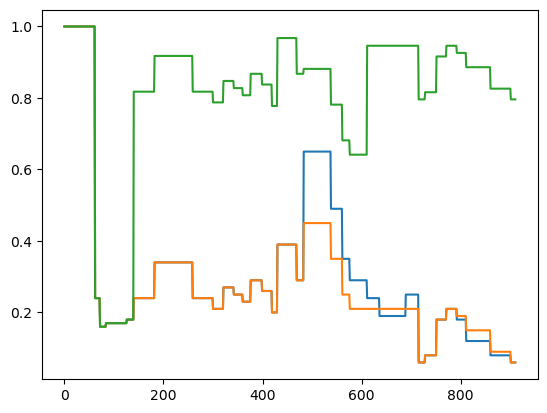

In [2]:
df=pd.read_csv('data/COVID_merged.csv', index_col=0,parse_dates=True)
#print(df)

df.drop(['mobility', 'm_smoothed','m_norm', 'shifted_sociality'], inplace = True, axis = 1)

# Define the reference date
reference_date = pd.to_datetime('2020-01-01')

# Calculate the number of days since the reference date
df.index = (df.index - reference_date).days

df.fillna(method = "bfill", inplace = True)
df.dropna(inplace = True)

# Define date for the end of the study

end_of_study = 14 + df.index.max()

print(df, end_of_study)

plt.plot(df)

In [3]:
data_meas = pd.read_csv('data/data_latest/mononodo_dati_2023_02_14.csv', skipinitialspace = True, 
                  usecols = ['tempo_dati', 'Var[CONTAGI-spe]', 'Var[CONTAGI-spe-lisc]'])

data_sim = pd.read_csv('data/data_latest/virus_mononodo_popolazioni.csv', skipinitialspace = True,
                  sep = "\t", usecols = ['t','Ne0','Pe0','Se0', 'Ee0', 'Ie0', 'Ae0', 'Ce0', 'RTe0', 'RHe0', 'RQe0', 'RCe0', 'GRe0', 'GOe0', 
                                        'De0', 'Ve0', 'Ne1', 'Pe1', 'Se1', 'Ee1', 'Ie1', 'Ae1', 'Ce1', 'RTe1', 'RHe1', 'RQe1', 'RCe1', 
                                        'GRe1', 'GOe1', 'De1', 'Ve1'])

# Remap full model into simplified compartments



compartments = ['N', 'P', 'S', 'E', 'I', 'A', 'C', 'RT', 'RH', 'RQ', 'RC', 'GR', 'GO', 'D', 'V']

for c in compartments:
    data_sim[c] = data_sim[c+'e0'] + data_sim[c+'e1']
    data_sim.drop([c+'e0', c+'e1'], axis = 1, inplace = True)

data_sim.rename(columns = {'t' : 'tempo_sim', 'A' : 'U'},inplace = True)

data_meas.rename(columns = {'tempo_dati' : 't_data', 'Var[CONTAGI-spe-lisc]' : 'NewPositives_smooth', 
                             'Var[CONTAGI-spe]': 'NewPositives'}, inplace = True)

data_meas = data_meas[data_meas.t_data < end_of_study]

total_population = 886891

# Pad initial missing data in the new positives, reindex, and remove t_data
data_meas.NewPositives.fillna(method = "bfill", inplace = True)
data_meas.NewPositives_smooth.fillna(method = "bfill", inplace = True)
data_meas.index = data_meas.t_data
data_meas.drop("t_data", axis = 1, inplace = True)

# Resample daily, cast to int and reindex, define c, which enter susceptivity as c_0
data_sim = data_sim.iloc[::24]
data_sim.tempo_sim += 44
data_sim['Phi_0'] = data_sim['C'].diff()
data_sim.index = data_sim.tempo_sim.astype(int)
data_sim = data_sim[data_sim.index < end_of_study]
data_sim.drop("tempo_sim", axis = 1, inplace = True)
# Estimate c_0 at the best of my possibilities as of 3/6/2024 NdC: è comunque molto sbagliato, dovrebbe essere S/P
# 12/6/2024 NdC: ora abbiamo i veri dati del modello!

# NB: mancano i vaccini! Vedi NdC sopra, ora ci sono! E comunque L fornisce anche P
data_sim.loc[:, 'c'] = [row.S / row.P for i, row in data_sim.iterrows()]

# # Get unreported from somewhere else (for the time being)
# initial_offset = 44
# data_simU  = pd.read_csv("data/mononodo_partial.csv", sep = "\t", usecols = ["t", "Ae1", "Ae2", "Av0", "Av1", "Av2"])
# data_simU  = data_simU.iloc[::24]
# data_simU.index = data_simU.t.astype(int) + initial_offset # Add initial offset!
# data_simU.drop('t', axis = 1, inplace = True)
# data_simU.loc[:,'U'] = [row.Ae1 + row.Ae2 for i, row in data_simU.iterrows()]
# data_simU.drop(["Ae1", "Ae2", "Av0", "Av1", "Av2"], axis = 1, inplace = True)

data_meas

,NewPositives,NewPositives_smooth
t_data,,
32.0,0.0,0.000000
33.0,0.0,0.000000
34.0,0.0,0.000000
35.0,0.0,0.000000
36.0,0.0,0.000000
...,...,...
919.0,1478.0,1481.285714
920.0,1515.0,1473.571429
921.0,1204.0,1465.000000


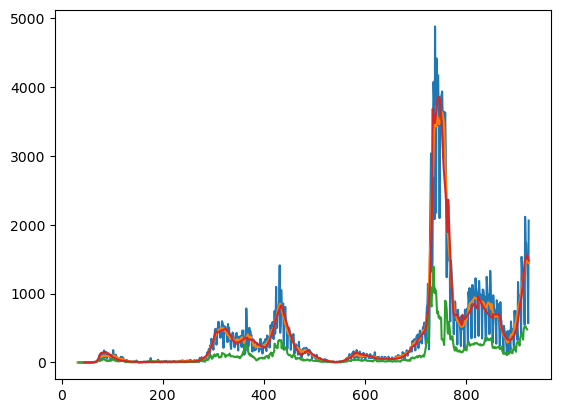

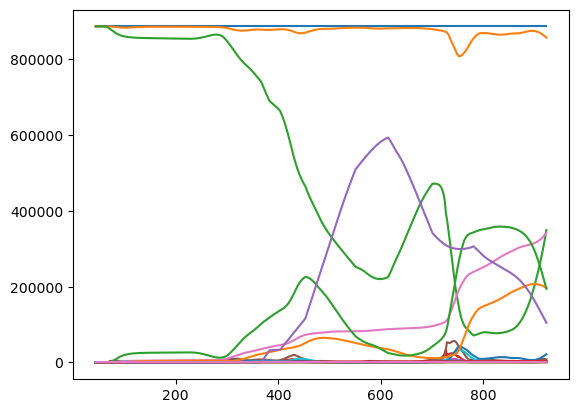

In [4]:
plt.figure()
for col in data_meas.columns:
    plt.plot(data_meas[col])
plt.plot(data_meas.NewPositives.rolling(window = 7, center = True).std())
plt.plot(data_sim.Phi_0)
plt.figure()
for col in data_sim.columns:
    plt.plot(data_sim[col])

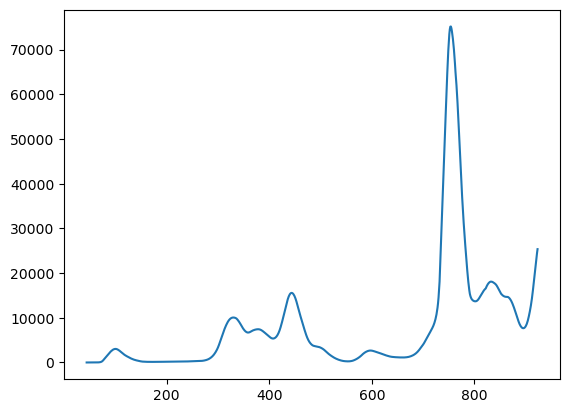

In [5]:
plt.plot(data_sim.RT + data_sim.RH + data_sim.RQ + data_sim.RC)

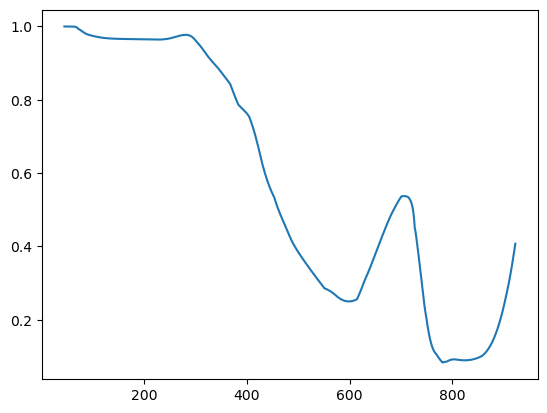

In [6]:
plt.plot(data_sim.c)

In [7]:
#sim_total = data_sim.merge(right = data_simU, left_index = True, right_index = True)
sim_total = data_sim
sim_total

,N,P,S,E,I,U,C,RT,RH,RQ,RC,GR,GO,D,V,Phi_0,c
tempo_sim,,,,,,,,,,,,,,,,,
44,886891,886891,886891.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.00,NaN,1.000000
45,886891,886891,886890.0,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.00,0.000000e+00,0.999999
46,886891,886891,886890.0,0.590267,0.057363,0.352370,2.226030e-08,1.970040e-09,1.284420e-08,6.221760e-09,1.224320e-09,0.0,1.279970e-07,0.00,0.00,2.226030e-08,0.999999
47,886891,886891,886889.0,0.718122,0.146254,0.898418,1.620880e-04,1.434480e-05,9.352480e-05,4.530360e-05,8.914840e-06,0.0,9.320060e-04,0.00,0.00,1.620657e-04,0.999998
48,886891,886891,886889.0,1.531068,0.145811,0.895691,3.652080e-03,3.232090e-04,2.107250e-03,1.020760e-03,2.008650e-04,0.0,2.099950e-02,0.00,0.00,3.489992e-03,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,886891,861491,318660.0,3374.950000,1187.019000,9246.070000,3.356757e+05,3.018380e+01,3.391420e+02,2.917510e+03,1.824829e+04,199998.7,2.140839e+05,3864.35,114940.36,1.548600e+03,0.369894
920,886891,860437,326125.0,3272.440000,1155.917000,9040.430000,3.372360e+05,3.057960e+01,3.440280e+02,3.059330e+03,1.914885e+04,199262.4,2.092161e+05,3870.96,112365.18,1.560300e+03,0.379023
921,886891,859429,333729.0,3162.450000,1122.292000,8799.670000,3.387868e+05,3.057190e+01,3.445310e+02,3.196830e+03,2.001211e+04,198500.4,2.043261e+05,3878.01,109788.96,1.550800e+03,0.388315


In [8]:
sim_meas = sim_total.merge(right = data_meas, left_index = True, right_index = True)
sim_meas

,N,P,S,E,I,U,C,RT,RH,RQ,RC,GR,GO,D,V,Phi_0,c,NewPositives,NewPositives_smooth
44.0,886891,886891,886891.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.00,NaN,1.000000,0.0,0.000000
45.0,886891,886891,886890.0,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.00,0.00,0.000000e+00,0.999999,0.0,0.000000
46.0,886891,886891,886890.0,0.590267,0.057363,0.352370,2.226030e-08,1.970040e-09,1.284420e-08,6.221760e-09,1.224320e-09,0.0,1.279970e-07,0.00,0.00,2.226030e-08,0.999999,0.0,0.000000
47.0,886891,886891,886889.0,0.718122,0.146254,0.898418,1.620880e-04,1.434480e-05,9.352480e-05,4.530360e-05,8.914840e-06,0.0,9.320060e-04,0.00,0.00,1.620657e-04,0.999998,0.0,0.000000
48.0,886891,886891,886889.0,1.531068,0.145811,0.895691,3.652080e-03,3.232090e-04,2.107250e-03,1.020760e-03,2.008650e-04,0.0,2.099950e-02,0.00,0.00,3.489992e-03,0.999998,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919.0,886891,861491,318660.0,3374.950000,1187.019000,9246.070000,3.356757e+05,3.018380e+01,3.391420e+02,2.917510e+03,1.824829e+04,199998.7,2.140839e+05,3864.35,114940.36,1.548600e+03,0.369894,1478.0,1481.285714
920.0,886891,860437,326125.0,3272.440000,1155.917000,9040.430000,3.372360e+05,3.057960e+01,3.440280e+02,3.059330e+03,1.914885e+04,199262.4,2.092161e+05,3870.96,112365.18,1.560300e+03,0.379023,1515.0,1473.571429
921.0,886891,859429,333729.0,3162.450000,1122.292000,8799.670000,3.387868e+05,3.057190e+01,3.445310e+02,3.196830e+03,2.001211e+04,198500.4,2.043261e+05,3878.01,109788.96,1.550800e+03,0.388315,1204.0,1465.000000
922.0,886891,858492,341465.0,3045.650000,1087.978000,8543.310000,3.403074e+05,3.028650e+01,3.419660e+02,3.325710e+03,2.081576e+04,197718.8,1.994200e+05,3885.27,107211.30,1.520600e+03,0.397750,570.0,1454.714286


In [9]:
from numpy import sqrt, nan
#total = sim_meas.merge(right = df, left_index = True, right_index = True)
total = df.join(sim_meas)

total = total.fillna(method = 'bfill').dropna()

winsize = 7

total.loc[:, "sigma_mean_NewPositives"] = data_meas.NewPositives.rolling(window = winsize, center = True).std() / sqrt(winsize - 1)
total.loc[:, "relative_sigma_mean_NewPositives"] = [row.sigma_mean_NewPositives / row.NewPositives_smooth 
                                                    if row.NewPositives_smooth > 0. else nan for i, row in total.iterrows()]

In [10]:
total.loc[61]

sociality                           1.000000e+00
sociality75pc                       1.000000e+00
shifted_sociality75pc               1.000000e+00
N                                   8.868910e+05
P                                   8.868880e+05
S                                   8.866890e+05
E                                   9.945730e+01
I                                   1.155362e+01
U                                   7.097230e+01
C                                   3.019717e+00
RT                                  3.489720e-01
RH                                  1.726609e+00
RQ                                  7.659194e-01
RC                                  1.660851e-01
GR                                  2.460660e-11
GO                                  1.736338e+01
D                                   1.214068e-02
V                                   0.000000e+00
Phi_0                               8.692130e-01
c                                   9.997756e-01
NewPositives        

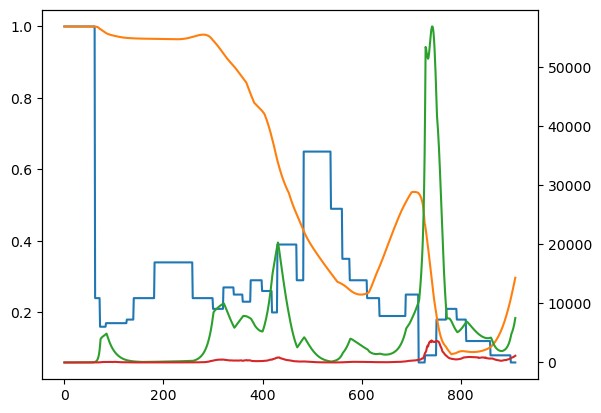

In [11]:
figtotal, axtotal = plt.subplots()

axtotal.plot(total.sociality)
axtotal.plot(total.c)

axpop = axtotal.twinx()

axpop.plot(total.U, color = 'C2')
axpop.plot(total.NewPositives_smooth, color = 'C3')

0.0      1.863615
1.0      1.863615
2.0      1.863615
3.0      1.863615
4.0      1.863615
           ...   
906.0   -2.121867
907.0   -2.106882
908.0   -2.092095
909.0   -2.077552
910.0   -2.063235
Name: mu, Length: 911, dtype: float64


Text(0, 0.5, '$\\mu(t)$')

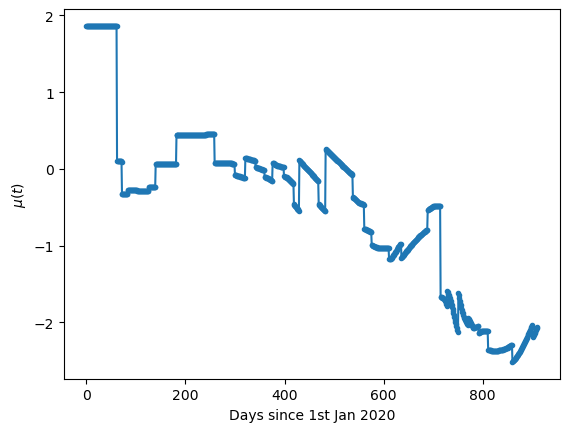

In [12]:
# Calculate Lyapunov exponents
from numpy import exp, isnan
from scipy.optimize import root_scalar

T_u     = 5.5
sigma_u = 2.3
T_e     = 2.0
sigma_e = 0.1
beta    = 1./1.2
m_base  = 0.7
c_0     = 1.0 
alpha   = .14

a       = T_u**2/sigma_u**2
b       = T_u/sigma_u**2

def sceq_mu(x, beta, c_0, m, T_u, T_e, alpha, a):
    return (1-(a**a)/(x+a)**a)*exp(-T_e*x/T_u) - x/(T_u*c_0*beta*m)

def find_root(beta, c_0, m, T_u, T_e, alpha, a):
    try:
        ret = root_scalar(sceq_mu, bracket = (- 10, -0.000001, ), method = 'bisect',
                    args=(beta, c_0, m, T_u, T_e, alpha, a))
    except ValueError:
        ret = root_scalar(sceq_mu, bracket = (0.000001, 10., ), method = 'bisect',
                    args=(beta, c_0, m, T_u, T_e, alpha, a))
    return ret
    
total.loc[:,'mu'] = [find_root(beta, row.c, row.sociality, T_u, T_e, alpha, a).root 
                            if not isnan(row.sociality) else nan for i, row in total.iterrows()]

print(total['mu'].dropna())

plt.plot(total['mu'], marker = '.')
plt.xlabel("Days since 1st Jan 2020")
plt.ylabel(r"$\mu(t)$")

In [13]:
from numpy import exp

def Fprime(x, beta, c_0, m, T_u, T_e, alpha, a):
    return exp(-T_e/T_u * x) * ((a/(x+a))**a * (a/(x+a) + T_e/T_u) - T_e/T_u)

def sus(x, beta, c, m, T_u, T_e, alpha, a):
    #print(x/(m - T_u * beta * (1 - alpha) * c_0 * m**2 * Fprime(x, beta, c_0, m, 
    #                                                              T_u, T_e, alpha, a)))
    return x/(m - T_u * beta * c * m**2 * Fprime(x, beta, c, m, 
                                                                   T_u, T_e, alpha, a))

total.loc[:,'susceptivity'] = [sus(row.mu, beta, row.c, row.sociality, T_u, T_e, alpha, a) for i, row in total.iterrows()]



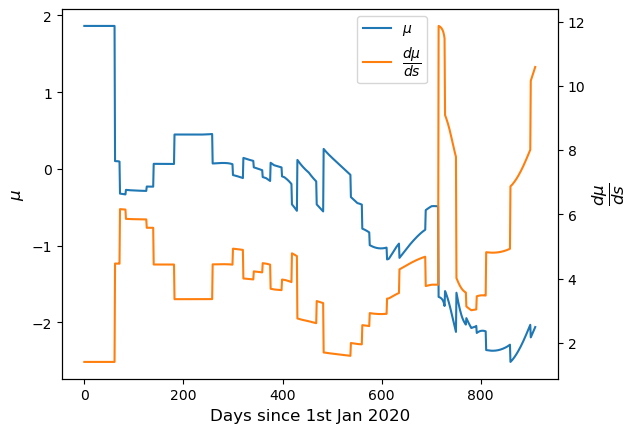

In [14]:
figlyap, axmu = plt.subplots()
axmu.plot(total['mu'], color = "C0", label = r"$\mu$")
axsus = axmu.twinx()
axsus.plot(total['susceptivity'], color = "C1", label =r"$\dfrac{d\mu}{ds}$")

axmu.set_xlabel("Days since 1st Jan 2020", fontsize = 12)
axmu.set_ylabel(r"$\mu$", fontsize = 12)
axsus.set_ylabel(r"$\dfrac{d\mu}{ds}$", fontsize =12)
figlyap.legend(loc="upper right", bbox_to_anchor=(0.75,1), bbox_transform=axmu.transAxes)

In [15]:
total

,sociality,sociality75pc,shifted_sociality75pc,N,P,S,E,I,U,C,...,D,V,Phi_0,c,NewPositives,NewPositives_smooth,sigma_mean_NewPositives,relative_sigma_mean_NewPositives,mu,susceptivity
0.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,0.00,0.0,0.0,1.000000,0.0,0.000000,NaN,NaN,1.863615,1.403434
1.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,0.00,0.0,0.0,1.000000,0.0,0.000000,NaN,NaN,1.863615,1.403434
2.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,0.00,0.0,0.0,1.000000,0.0,0.000000,NaN,NaN,1.863615,1.403434
3.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,0.00,0.0,0.0,1.000000,0.0,0.000000,NaN,NaN,1.863615,1.403434
4.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,0.00,0.0,0.0,1.000000,0.0,0.000000,NaN,NaN,1.863615,1.403434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906.0,0.06,0.06,0.796065,886891.0,872756.0,236217.0,3094.48,795.874,5792.49,319454.5,...,3809.58,147893.2,841.9,0.270656,972.0,912.428571,139.582285,0.152979,-2.121867,10.397250
907.0,0.06,0.06,0.796065,886891.0,872213.0,241796.0,3341.51,842.599,6132.56,320335.1,...,3812.46,145416.8,880.6,0.277221,665.0,970.857143,154.337010,0.158970,-2.106882,10.445038
908.0,0.06,0.06,0.796065,886891.0,871632.0,247391.0,3624.01,897.198,6529.94,321256.9,...,3815.46,142926.9,921.8,0.283825,415.0,1033.142857,166.637736,0.161292,-2.092095,10.492252
909.0,0.06,0.06,0.796065,886891.0,871004.0,252977.0,3950.69,960.360,6989.64,322225.7,...,3818.70,140425.2,968.8,0.290443,1535.0,1080.428571,168.487694,0.155945,-2.077552,10.538740


In [16]:
from numpy import array, append, where
# Calculate susceptivity of flows

def susPhi(Deltat, T_u, mu_0, sus_0, U_0):
    if Deltat < T_u+2:
        return 0.
    elif Deltat < 2+2*T_u:
        return alpha*U_0 * exp((Deltat-T_u)/T_u * mu_0) * sus_0 * (mu_0 * (Deltat - T_u)/T_u + 1) / T_u
    else:
        return alpha*U_0 * exp((Deltat-T_u)/T_u * mu_0) * sus_0 * (mu_0 * (Deltat - T_u)/T_u + 1) / T_u + susPhi(Deltat - T_u, T_u, mu_0, sus_0, U_0)

def avgsusPhi(T_u, mu_0, sus_0, U_0):
    return alpha * U_0 * sus_0 * exp(mu_0) /T_u
#    return alpha * U_0 * sus_0 * exp(2 * mu_0) /T_u
#    return alpha * U_0 * sus_0 * (2*exp(2*mu_0) - exp(mu_0)) / T_u

# Multiplied by alpha since this outgoing flow accounts both for symptomatic and asymptomatic

lmu_0 = [] # List mu_0, the fixed Lyap exponent at the plateau beginning
lsus_0= [] # List sus_0 same but for the susceptivity
lU_0  = [] # List U_0 unreported population at the beginning of the plateau
ldslc = [] # List "Days since last change" to be used in the flow susceptivity
lc_0  = [] # List "Days since last change" to be used in the flow susceptivity
lbaselinePhi = []
lsigmaNP = []


changing_days   = [idx for idx, row in enumerate(total.sociality.diff()) if row != 0.]

changing_days += [len(total)]

for i in range(len(changing_days[:-1])):
    plateau_length = changing_days[i+1] - changing_days[i]
    print(plateau_length)
    tmpmu   = [total.mu.iloc[changing_days[i]]] * plateau_length
    tmpsus  = [total.susceptivity.iloc[changing_days[i]]] * plateau_length
    tmpU    = [total.U.iloc[changing_days[i]]] * plateau_length
    tmpbaselinePhi = [total.Phi_0.iloc[changing_days[i] + int(T_u):changing_days[i] + min(2* int(T_u), plateau_length)].mean()] * plateau_length
    tmpsigmaNP = [total.sigma_mean_NewPositives.iloc[changing_days[i] + int(T_u):changing_days[i] + min(2* int(T_u), plateau_length)].mean()] * plateau_length
    lmu_0  += tmpmu
    lsus_0 += tmpsus
    lU_0   += tmpU
    ldslc  += [i for i in range(plateau_length)]
    lc_0   += [total.c.iloc[changing_days[i]]] * plateau_length
    lbaselinePhi += tmpbaselinePhi
    lsigmaNP+= tmpsigmaNP

total.loc[:, 'mu_0']  = lmu_0
total.loc[:, 'sus_0'] = lsus_0
total.loc[:, 'dslc']  = ldslc
total.loc[:, 'U_0']   = lU_0
total.loc[:, 'c_0']   = lc_0
total.loc[:, 'baselinePhi'] = lbaselinePhi
total.loc[:, 'sigmaNP'] = lsigmaNP
total.loc[:, 'relative_sigmaNP'] = total.loc[:, 'sigmaNP'] / total.loc[:, 'baselinePhi']

total

62
10
12
42
14
42
77
41
21
21
18
16
23
20
11
39
14
55
23
15
35
25
53
26
13
23
20
21
19
49
41
10


,sociality,sociality75pc,shifted_sociality75pc,N,P,S,E,I,U,C,...,mu,susceptivity,mu_0,sus_0,dslc,U_0,c_0,baselinePhi,sigmaNP,relative_sigmaNP
0.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,1.863615,1.403434,1.863615,1.403434,0,0.00,1.000000,0.00,NaN,NaN
1.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,1.863615,1.403434,1.863615,1.403434,1,0.00,1.000000,0.00,NaN,NaN
2.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,1.863615,1.403434,1.863615,1.403434,2,0.00,1.000000,0.00,NaN,NaN
3.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,1.863615,1.403434,1.863615,1.403434,3,0.00,1.000000,0.00,NaN,NaN
4.0,1.00,1.00,1.000000,886891.0,886891.0,886891.0,0.00,0.000,0.00,0.0,...,1.863615,1.403434,1.863615,1.403434,4,0.00,1.000000,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906.0,0.06,0.06,0.796065,886891.0,872756.0,236217.0,3094.48,795.874,5792.49,319454.5,...,-2.121867,10.397250,-2.198081,10.155112,5,4408.06,0.239184,928.04,160.146906,0.172565
907.0,0.06,0.06,0.796065,886891.0,872213.0,241796.0,3341.51,842.599,6132.56,320335.1,...,-2.106882,10.445038,-2.198081,10.155112,6,4408.06,0.239184,928.04,160.146906,0.172565
908.0,0.06,0.06,0.796065,886891.0,871632.0,247391.0,3624.01,897.198,6529.94,321256.9,...,-2.092095,10.492252,-2.198081,10.155112,7,4408.06,0.239184,928.04,160.146906,0.172565
909.0,0.06,0.06,0.796065,886891.0,871004.0,252977.0,3950.69,960.360,6989.64,322225.7,...,-2.077552,10.538740,-2.198081,10.155112,8,4408.06,0.239184,928.04,160.146906,0.172565


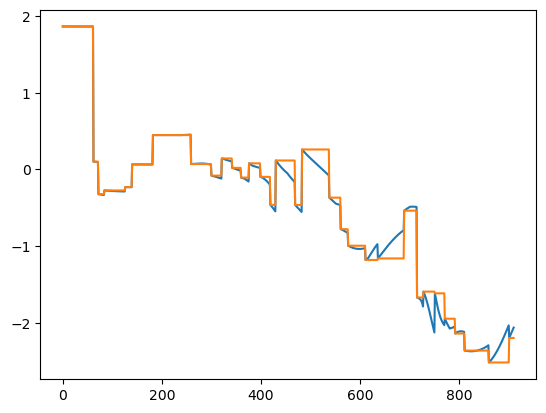

In [17]:
plt.plot(total.mu)
plt.plot(total.mu_0)

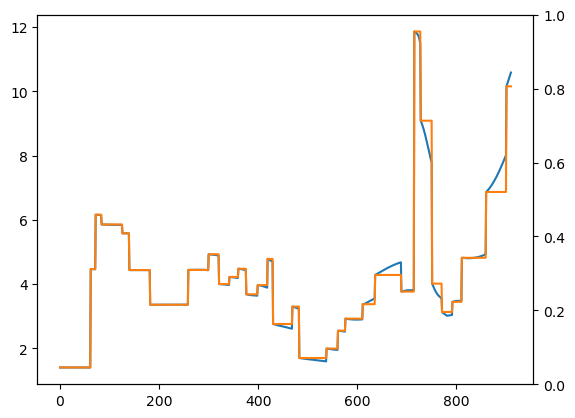

In [18]:
figsus, axsus = plt.subplots()
axsus.plot(total.susceptivity)
axsus.plot(total.sus_0)
axrel = axsus.twinx()

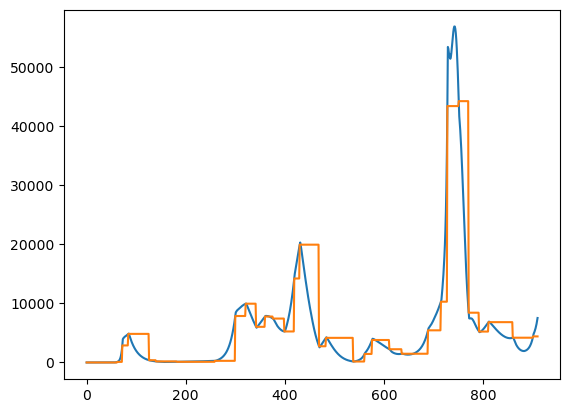

In [19]:
plt.plot(total.U)
plt.plot(total.U_0)

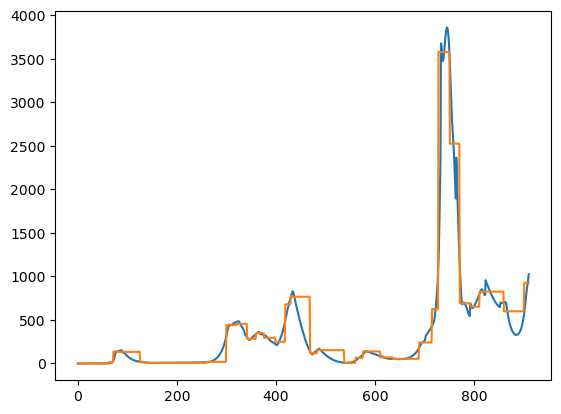

In [20]:
plt.plot(total.Phi_0)
plt.plot(total.baselinePhi)

In [21]:
total.loc[:, "susPhi"] = [susPhi(row.dslc, T_u, row.mu_0, row.sus_0, row.U_0) if row.dslc <= 2*T_u else nan for i, row in total.iterrows()]
total.loc[:, "avgsusPhi"] = [avgsusPhi(T_u, row.mu_0, row.sus_0, row.U_0) if row.dslc <= 2*T_u else nan for i, row in total.iterrows()]
total.loc[:, 'relative_sus_Phi'] = [row.susPhi / row.Phi_0 if row.Phi_0 > 0. else nan for i, row in total.iterrows()]
total.loc[:, 'relative_avgsusPhi'] = [row.avgsusPhi / row.baselinePhi if row.baselinePhi > 0. else nan for i, row in total.iterrows()]


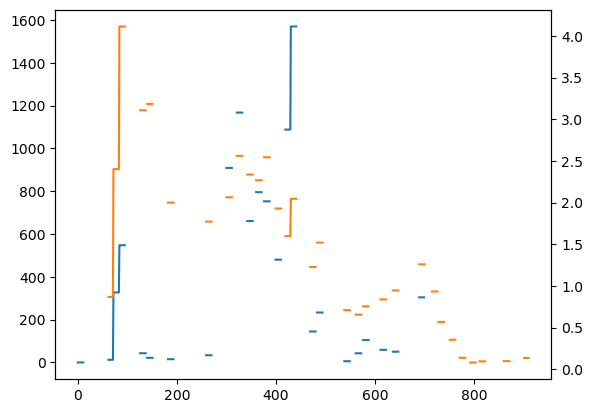

In [22]:
figsus, axsus = plt.subplots()

#axsus.plot(total.susPhi[total.index < 700])
axsus.plot(total.avgsusPhi[total.index < 700])

axrel = axsus.twinx()

axrel.plot(total.relative_avgsusPhi, color = "C1")
#axrel.set_xlim()

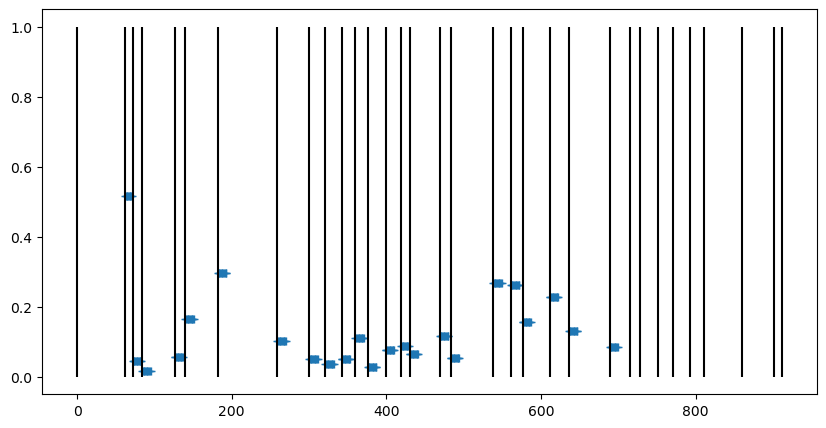

In [23]:
total.loc[:, "sigma_s"] = [row.relative_sigmaNP / row.relative_avgsusPhi if row.relative_avgsusPhi != 0. else nan for i, row in total.iterrows()]
plt.figure(figsize = (10,5))
plt.plot(total.sigma_s[total.index < 700], marker = "+", linewidth = 0)
plt.vlines(changing_days, ymin=0., ymax = 1, colors='k', linestyles='solid')

In [25]:
from numpy import full, abs

mean_sigmas = full(shape = (len(changing_days)), fill_value=0.)

prediction_begin = T_u
prediction_end   = 2*T_u

for i in range(len(changing_days)-1):
    mean_sigmas[i] = total.iloc[changing_days[i]].sigma_s

# vals = []

# for i in range(len(changing_days)-1):
#     plateau_length = changing_days[i+1] - changing_days[i]
#     print()
#     if plateau_length <= prediction_end:
#         errs = total.iloc[changing_days[i]:changing_days[i+1]].sigma_s
#         vals.append(errs.dropna())
#         ms = errs.sum()/plateau_length
#         print(ms, plateau_length)
#         mean_sigmas[i] = abs(ms)
#     else:
#         errs = total.iloc[changing_days[i]:changing_days[i]+prediction_size].sigma_s
#         vals.append(errs.dropna())
#         ms = errs.sum()/prediction_size
#         print(ms, prediction_size)
#         mean_sigmas[i] = abs(ms)
# vals
#plt.plot(days, abs(mean_sigmas)[:-1])
# plt.yscale('log')
#for i in range(len(changing_days[:-1])):
#    print(changing_days[i], svals[i], mean_sigmas[i])

Text(0, 0.5, 'New reported cases (measured)')

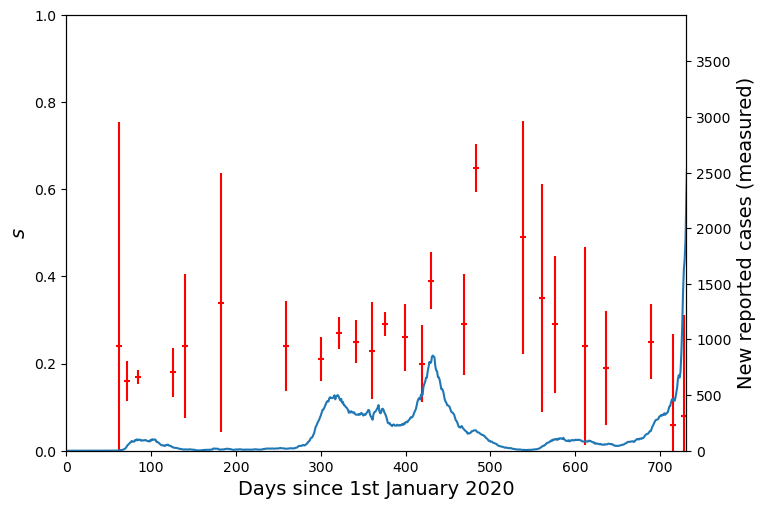

In [26]:
fig_uncertainties, ax_uncertainties = plt.subplots(figsize = (8, 8/sqrt(2)))

days = total.sociality[changing_days[:-1]].index
svals= total.sociality[changing_days[:-1]].values
ax_uncertainties.set_xlabel("Days since 1st January 2020", fontsize = 14)
ax_uncertainties.set_ylabel(r"$s$", fontsize = 14)
ax_uncertainties.errorbar(days[1:], svals[1:], yerr = abs(mean_sigmas[1:-1]), linestyle = '', c = 'r')
ax_uncertainties.scatter(days, svals, marker = '_', c = 'r', s = 20)
ax_uncertainties.set_ylim(bottom = 0.)#ax_uncertainties.plot(total.relative_sus_Phi)

ax_uncertainties.set_ylim(bottom = 0, top = 1 )
ax_popfinal = ax_uncertainties.twinx()
ax_popfinal.plot(total.NewPositives_smooth)
ax_popfinal.set_xlim(left = 0., right = 366+365)
ax_popfinal.set_ylim(bottom = 0.)
ax_popfinal.set_ylabel("New reported cases (measured)", fontsize = 14)

#fig_uncertainties.savefig("ds2.pdf")

nan


(array([2., 2., 6., 3., 1., 3., 0., 2., 0.]),
 array([0.        , 0.02222222, 0.04444444, 0.06666667, 0.08888889,
        0.11111111, 0.13333333, 0.15555556, 0.17777778, 0.2       ]),
 <BarContainer object of 9 artists>)

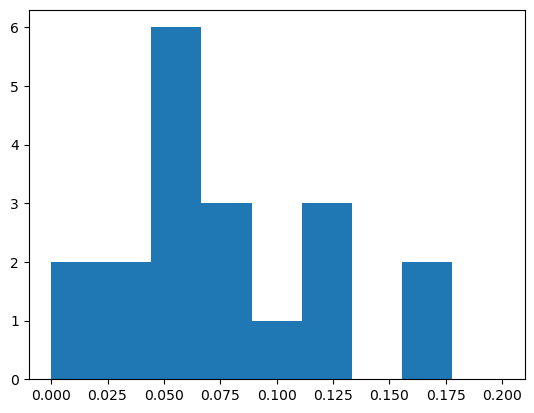

In [27]:
from numpy import linspace, logspace, log10
print(min(abs(mean_sigmas)))
plt.hist(abs(mean_sigmas), bins = linspace(0, 0.2, 10))

In [28]:
print("Mean uncertainty =", abs(mean_sigmas).mean())

Mean uncertainty = nan


In [29]:
total.columns

Index(['sociality', 'sociality75pc', 'shifted_sociality75pc', 'N', 'P', 'S',
       'E', 'I', 'U', 'C', 'RT', 'RH', 'RQ', 'RC', 'GR', 'GO', 'D', 'V',
       'Phi_0', 'c', 'NewPositives', 'NewPositives_smooth',
       'sigma_mean_NewPositives', 'relative_sigma_mean_NewPositives', 'mu',
       'susceptivity', 'mu_0', 'sus_0', 'dslc', 'U_0', 'c_0', 'baselinePhi',
       'sigmaNP', 'relative_sigmaNP', 'susPhi', 'avgsusPhi',
       'relative_sus_Phi', 'relative_avgsusPhi', 'sigma_s'],
      dtype='object')

MAE = 42.3213894411619
RMSE = 97.0017169040251


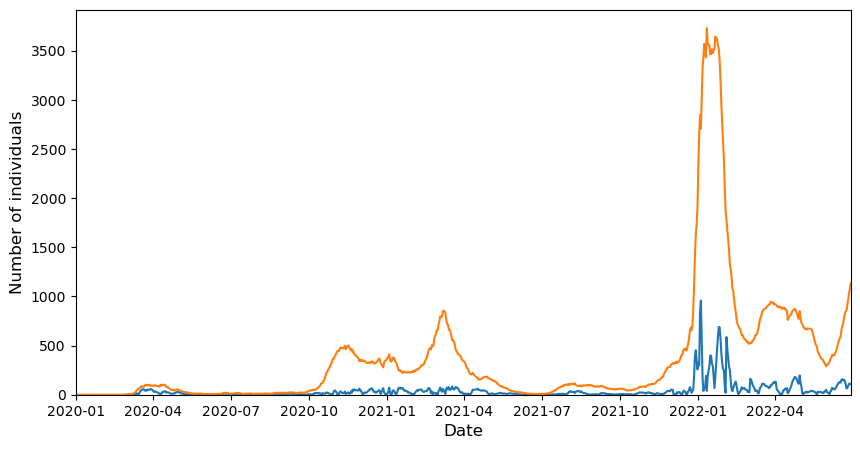

In [30]:
# KS-like
from numpy import sqrt, inf
fig, ax = plt.subplots(figsize = (10,5))
#total['relative_error'] = sqrt(((total.NewPositives_smooth - total.Phi_0)/total.NewPositives_smooth)**2)[(total.NewPositives != 0)]
total['error'] = sqrt((total.NewPositives_smooth - total.Phi_0)**2)[(total.NewPositives != 0)]

from datetime import datetime, timedelta

total.index = total.index.astype(int)

def days_to_datetime(days): 
    base_date = datetime(2020, 1, 1) 
    delta = timedelta(days=days) # Subtract 1 day since we start counting from January 1, 2020 
    result_date = base_date + delta 
    return result_date
total['date'] = [days_to_datetime(idx) for idx, row in total.iterrows()]

myFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(myFmt)

ax.plot(total.date, total.error)
ax.plot(total.date, total.NewPositives_smooth, c = "C1")

ax.set_ylabel("Number of individuals", fontsize = 12)
ax.set_xlabel("Date", fontsize = 12)

ax.set_xlim(left = days_to_datetime(0), right = days_to_datetime(910))
ax.set_ylim(bottom = 0)
re = total.error.iloc[44:]
#re.replace([inf, -inf], nan, inplace=True)
#re.dropna(inplace = True)
print("MAE =", re.mean())
print("RMSE =",sqrt((((total.NewPositives_smooth - total.Phi_0)).iloc[44:]**2).mean()))
fig.savefig("AE.png", dpi = 300, bbox_inches = "tight")

In [31]:
910 - 44

866

LinregressResult(slope=-0.012635438095464755, intercept=-5.063008176419599, rvalue=-0.9032044972511745, pvalue=4.963282583034506e-08, stderr=0.0014152666667150155, intercept_stderr=0.31350455016307155)
Truncation probability = 79.14248737912226


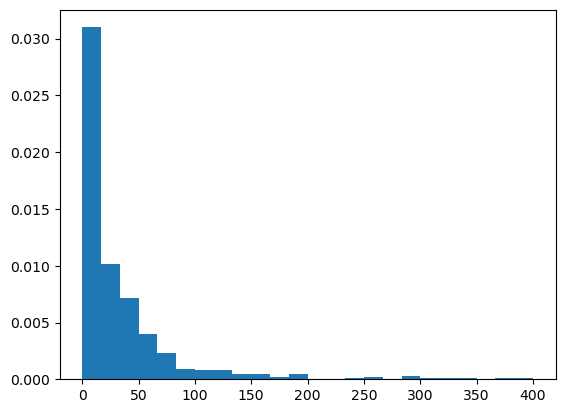

In [32]:
densities, bins, _ = plt.hist(re, bins = linspace(0, 400, 25), density = True)
xs = .5 * (bins[1:] + bins[:-1])

from numpy import log, isclose, logical_not
from scipy.stats import linregress

zeromask = logical_not(isclose(densities, 0))

logdensities = log(densities[zeromask])

logdensities

fit = linregress(xs[zeromask], logdensities)
print(fit)
print("Truncation probability =", 1./(abs(fit.slope)))
#plt.yscale('log')

In [33]:
data_meas

,NewPositives,NewPositives_smooth
t_data,,
32.0,0.0,0.000000
33.0,0.0,0.000000
34.0,0.0,0.000000
35.0,0.0,0.000000
36.0,0.0,0.000000
...,...,...
919.0,1478.0,1481.285714
920.0,1515.0,1473.571429
921.0,1204.0,1465.000000


In [94]:
data_red = pd.read_csv("./data/effetto_riduzione_efficacia_vaccini.csv", usecols = (1, 2, 3, 4, 5)).iloc[13:1069]
data_red['tempo'] = [days_to_datetime(row["tempo"]) for idx, row in data_red.iterrows()]

data_red.rename(columns = { 'tempo' : 'date', 'Var[CONTAGI-spe-lisc]' : 'exp-ravg', 'Var[CONTAGI-spe]' : 'exp', 
                           'Var[CONTAGI (previsione)]' : 'pred', 'Var[CONTAGI (riduzione effetto vaccini)]' : 'newpred'},inplace = True)

data_red

,date,exp,exp-ravg,pred,newpred
13,2020-02-15,NaN,NaN,0,0
14,2020-02-16,NaN,NaN,2.22603E-08,2.22603E-08
15,2020-02-17,NaN,NaN,0.0001620657397,0.0001620657397
16,2020-02-18,NaN,NaN,0.003489992,0.003489992
17,2020-02-19,NaN,NaN,0.01343372,0.01343372
...,...,...,...,...,...
1064,2023-01-01,192.0,243.000000,172,101
1065,2023-01-02,82.0,231.285714,165,98
1066,2023-01-03,291.0,211.142857,160,95
1067,2023-01-04,222.0,181.000000,155,93


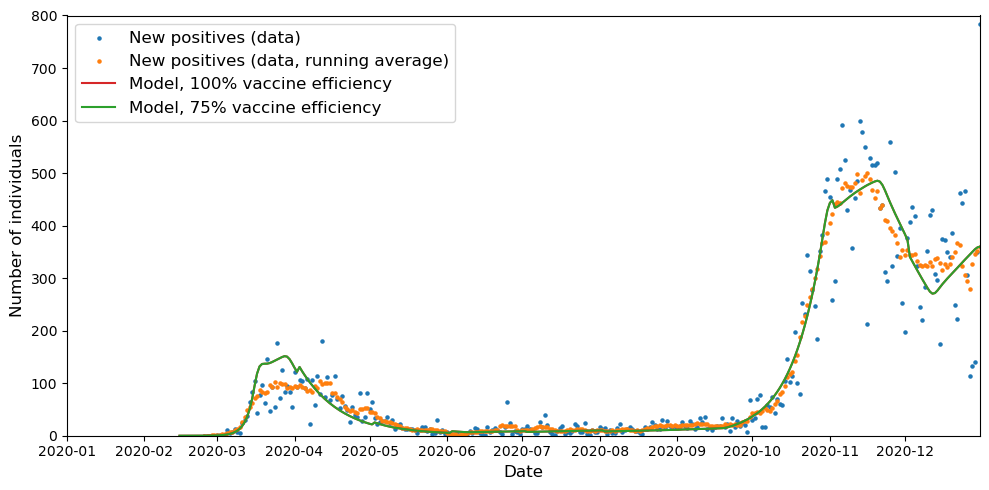

In [124]:
fig1, ax1 = plt.subplots(figsize = (10,5))

myFmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(myFmt)

ax1.set_ylabel("Number of individuals", fontsize = 12)
ax1.set_xlabel("Date", fontsize = 12)

ax1.set_xlim(left = days_to_datetime(0), right = days_to_datetime(365))
ax1.set_ylim(bottom = 0, top = 800)
re = total.error.iloc[44:]

ax1.scatter(data_red.date, data_red["exp"], label = "New positives (data)", s = 5)
ax1.scatter(data_red.date, data_red["exp-ravg"], label = "New positives (data, running average)", s = 5)
ax1.plot(data_red.date, data_red["pred"].astype(float), label = "Model, 100% vaccine efficiency", color = "C3")
ax1.plot(data_red.date, data_red["newpred"].astype(float), label = "Model, 75% vaccine efficiency", color = "C2")
ax1.legend(loc = "upper left", fontsize = 12)
plt.tight_layout()
plt.savefig("comparison_vaccines_2020.pdf", transparent = True)

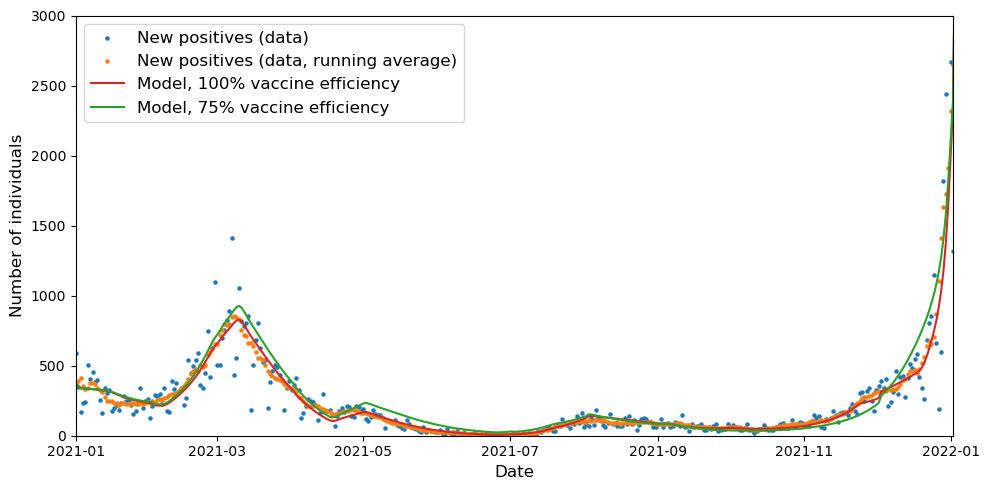

In [125]:
fig2, ax2 = plt.subplots(figsize = (10,5))

myFmt = mdates.DateFormatter('%Y-%m')
ax2.xaxis.set_major_formatter(myFmt)

ax2.set_ylabel("Number of individuals", fontsize = 12)
ax2.set_xlabel("Date", fontsize = 12)

ax2.set_xlim(left = days_to_datetime(366), right = days_to_datetime(732))
ax2.set_ylim(bottom = 0, top = 3000)
re = total.error.iloc[44:]

ax2.scatter(data_red.date, data_red["exp"], label = "New positives (data)", s = 5)
ax2.scatter(data_red.date, data_red["exp-ravg"], label = "New positives (data, running average)", s = 5)
ax2.plot(data_red.date, data_red["pred"].astype(float), label = "Model, 100% vaccine efficiency", color = "C3")
ax2.plot(data_red.date, data_red["newpred"].astype(float), label = "Model, 75% vaccine efficiency", color = "C2")
ax2.legend(loc = "upper left", fontsize = 12)
plt.tight_layout()
plt.savefig("comparison_vaccines_2021.pdf", transparent = True)